# Sampyo

1. classification model
2. 7class
3. 2.5% + 5%

## Import module

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import random

Using TensorFlow backend.
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cai/anaconda3/envs/MRCNN/l

## train data / test data

In [2]:
dataset_name = "./crop_dataset_water"

x_train = []
y_train = []
x_test = []
y_test = []

folder_list = os.listdir(dataset_name)
folder_list.sort()

In [3]:
folder_list25 = []
folder_list5 = []
for i in folder_list:
    if i[-3] == '.':
        folder_list25.append(i)
    else:
        folder_list5.append(i)

In [4]:
folder_list25

['FM_2.4_2.5%',
 'FM_2.6_2.5%',
 'FM_2.8_2.5%',
 'FM_3.0_2.5%',
 'FM_3.2_2.5%',
 'FM_3.4_2.5%',
 'FM_3.61_2.5%']

In [5]:
for one_folder in folder_list25:
    splited_one_folder =  one_folder.split("_")
    eveloped_one_folder = splited_one_folder[0]+"_"+splited_one_folder[1]
    # eveloped_one_folder : FM_classnum
    print(one_folder)
    
    join_folder_path = os.path.join(dataset_name, one_folder)
    # dataset folder path
    data_list = os.listdir(join_folder_path)
    # data list in folder
    
    ## sampling 300 images
    sampled_list = random.sample(data_list, 800)
    ## train / test = 8:2
    test_list = random.sample(sampled_list, int(len(sampled_list) * 0.2))
    
    for one_data in sampled_list:
        join_data_path = os.path.join(join_folder_path, one_data)
        # each data path
        
        ### imread / resize / normalize
        img = cv2.imread(join_data_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (512,512))
        img = cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img = np.reshape(img, (512,512,1)) # one channel

        # train
        if not one_data in test_list:
            # if data is not in test_list which is sampled before, add data in x_train, and class in y_train
            x_train.append(img)
            y_train.append(eveloped_one_folder)
            
        elif one_data in test_list:
            x_test.append(img)
            y_test.append(eveloped_one_folder)
    print(len(x_train))

            
tmp = [[x,y] for x,y in zip(x_train, y_train)]
random.shuffle(tmp)

x_train = [n[0] for n in tmp]
y_train = [n[1] for n in tmp]
            
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)  
y_test = np.array(y_test)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

FM_2.4_2.5%
640
FM_2.6_2.5%
1280
FM_2.8_2.5%
1920
FM_3.0_2.5%
2560
FM_3.2_2.5%
3200
FM_3.4_2.5%
3840
FM_3.61_2.5%
4480
(4480, 512, 512, 1)
(4480,)
(1120, 512, 512, 1)
(1120,)


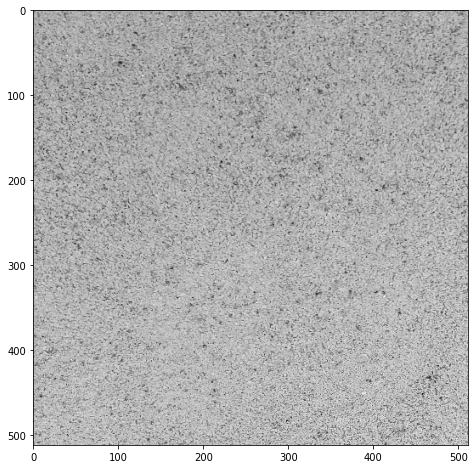

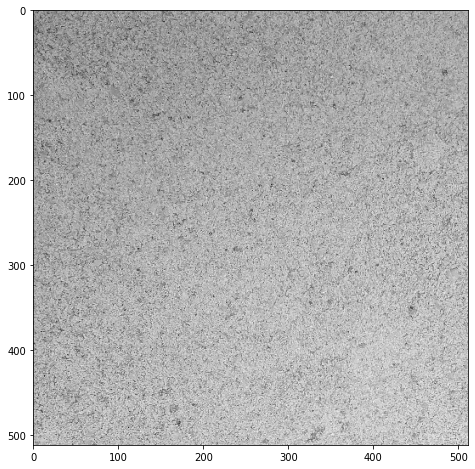

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(x_train[1].reshape(512,512), cmap="gray")

plt.figure(figsize=(8,8))
plt.imshow(x_test[0].reshape(512,512), cmap="gray")

## Y data onehot encoding

* ex1) 2 -> [1,0,0,0,0,0]
* ex2) 7 -> [0,0,0,0,0,1]

In [7]:
from sklearn.preprocessing import OneHotEncoder

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

enc = OneHotEncoder()
enc.fit(y_train)

y_train_onehot = enc.transform(y_train).toarray()
y_test_onehot = enc.transform(y_test).toarray()

print(y_test_onehot)
print(y_test)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[['FM_2.4']
 ['FM_2.4']
 ['FM_2.4']
 ...
 ['FM_3.61']
 ['FM_3.61']
 ['FM_3.61']]


## Import keras module

In [8]:
import keras

from keras.layers import Conv2D
from keras.layers import LeakyReLU
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

from keras.utils import multi_gpu_model

from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

## Deep Learning Model

In [9]:
inputs = Input((512, 512, 1))

# Layer 1
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(inputs)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 2
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 3
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 4
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 5
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 6
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

# Layer 7
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Conv2D(filters = 128, kernel_size = 3, strides = 1, \
            padding = "same", activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = MaxPooling2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)
x = Dense(128, activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
x = Dense(64, activation = keras.layers.LeakyReLU(alpha=0.1),kernel_initializer="glorot_normal")(x)
outputs = Dense(7, activation = 'softmax',kernel_initializer="glorot_normal")(x)

model = Model(inputs=[inputs], outputs=[outputs])

#model.summary()
# keras.utils.vis_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# from IPython.display import Image
# Image("model_plot.png")

Instructions for updating:
Colocations handled automatically by placer.


/home/cai/anaconda3/envs/MRCNN/lib/python3.6/site-packages/keras/activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 512, 512, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 128)     1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 128)     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     0         
__________

In [11]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train_onehot,y_val_onehot = train_test_split(x_train,y_train_onehot, test_size = 0.1, shuffle = True, random_state = 42)

In [12]:
#early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', verbose = 0, patience = 20, mode = 'auto')

#checkpoint
checkpoint_path = './minyoung_checkpoint/cp--2.5percent800--{epoch:04d}.ckpt'
cp_dir = os.path.dirname(checkpoint_path)
checkpoint_5epoch = keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, verbose = 1, period = 50)

## Learning

Instructions for updating:
Use tf.cast instead.
Train on 4032 samples, validate on 448 samples
Epoch 1/200
4032/4032 [==============================] - 119s 30ms/step - loss: 1.9459 - acc: 0.1265 - val_loss: 1.9459 - val_acc: 0.1295
Epoch 2/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.9459 - acc: 0.1248 - val_loss: 1.9459 - val_acc: 0.1295
Epoch 3/200
4032/4032 [==============================] - 115s 28ms/step - loss: 1.9459 - acc: 0.1376 - val_loss: 1.9459 - val_acc: 0.1295
Epoch 4/200
4032/4032 [==============================] - 115s 28ms/step - loss: 1.9459 - acc: 0.1411 - val_loss: 1.9459 - val_acc: 0.1295
Epoch 5/200
4032/4032 [==============================] - 115s 29ms/step - loss: 1.9459 - acc: 0.1376 - val_loss: 1.9459 - val_acc: 0.1295
Epoch 6/200
4032/4032 [==============================] - 115s 29ms/step - loss: 1.9459 - acc: 0.1453 - val_loss: 1.9459 - val_acc: 0.1295
Epoch 7/200
4032/4032 [==============================] - 115s 29ms/step - los

4032/4032 [==============================] - 114s 28ms/step - loss: 1.7503 - acc: 0.2798 - val_loss: 1.7709 - val_acc: 0.2478
Epoch 57/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.7515 - acc: 0.2793 - val_loss: 1.8059 - val_acc: 0.2701
Epoch 58/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.7462 - acc: 0.2825 - val_loss: 1.7790 - val_acc: 0.2589
Epoch 59/200
4032/4032 [==============================] - 115s 28ms/step - loss: 1.7407 - acc: 0.2825 - val_loss: 1.7564 - val_acc: 0.2679
Epoch 60/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.7332 - acc: 0.2887 - val_loss: 1.7479 - val_acc: 0.2701
Epoch 61/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.7294 - acc: 0.2904 - val_loss: 1.7449 - val_acc: 0.2879
Epoch 62/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.7225 - acc: 0.2917 - val_loss: 1.7388 - val_acc: 0.2612
Epoch 63/200
4032/4032 [================

Epoch 114/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.5252 - acc: 0.3735 - val_loss: 1.5101 - val_acc: 0.3728
Epoch 115/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.5330 - acc: 0.3723 - val_loss: 1.4986 - val_acc: 0.3929
Epoch 116/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.5208 - acc: 0.3762 - val_loss: 1.5440 - val_acc: 0.3817
Epoch 117/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.5154 - acc: 0.3819 - val_loss: 1.4810 - val_acc: 0.3839
Epoch 118/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.5113 - acc: 0.3770 - val_loss: 1.5060 - val_acc: 0.3772
Epoch 119/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.5003 - acc: 0.3904 - val_loss: 1.4806 - val_acc: 0.3638
Epoch 120/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.5005 - acc: 0.3904 - val_loss: 1.5187 - val_acc: 0.3504
Epoch 121/200
4032/4

4032/4032 [==============================] - 114s 28ms/step - loss: 1.3197 - acc: 0.4700 - val_loss: 1.3000 - val_acc: 0.4643
Epoch 172/200
4032/4032 [==============================] - 113s 28ms/step - loss: 1.3193 - acc: 0.4655 - val_loss: 1.3284 - val_acc: 0.4531
Epoch 173/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.3174 - acc: 0.4628 - val_loss: 1.3755 - val_acc: 0.3996
Epoch 174/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.3186 - acc: 0.4665 - val_loss: 1.3469 - val_acc: 0.4554
Epoch 175/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.3039 - acc: 0.4685 - val_loss: 1.3364 - val_acc: 0.4531
Epoch 176/200
4032/4032 [==============================] - 114s 28ms/step - loss: 1.3059 - acc: 0.4690 - val_loss: 1.3767 - val_acc: 0.4397
Epoch 177/200
4032/4032 [==============================] - 115s 28ms/step - loss: 1.3043 - acc: 0.4702 - val_loss: 1.2871 - val_acc: 0.4732
Epoch 178/200
4032/4032 [=========

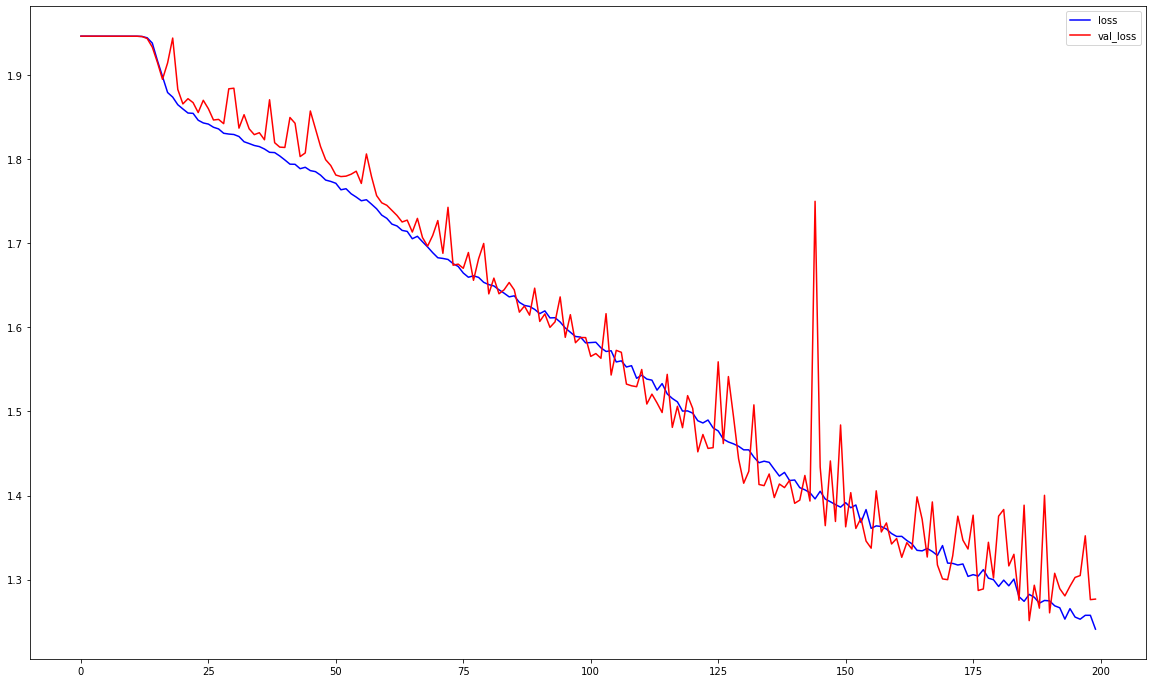

In [13]:
parallel_model = multi_gpu_model(model,gpus=2)

# callback
# early_stopping = EarlyStopping(monitor='val_loss',patience = 30)

# optimizer
adam = keras.optimizers.Adam(lr=0.000001)
parallel_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# fit model
hist = parallel_model.fit(x_train, y_train_onehot,\
                          epochs=200, batch_size=4,\
                          validation_data=(x_val, y_val_onehot),\
                         callbacks = [checkpoint_5epoch])

# plot loss & val_loss
plt.figure(figsize=(20,12))
plt.plot(hist.history['loss'],'b',label='loss')
plt.plot(hist.history['val_loss'],'r',label='val_loss')
#plt.xticks(np.arange(0,50,1))
plt.legend(loc="upper right");

## Predict

In [14]:
pred_y = parallel_model.predict(x_test)


In [15]:
y_test_onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [16]:
pred_y = np.argmax(pred_y,axis=1 )
real_y = np.argmax(y_test_onehot,axis=1)

print(pred_y)
print(real_y)

[3 0 3 ... 6 6 2]
[0 0 0 ... 6 6 6]


In [17]:
corr_num1 = 0
corr_num2 = 0
for i in range(real_y.shape[0]):
    if pred_y[i] == real_y[i]:
        corr_num1 += 1
        
    if abs(int(pred_y[i]) - int(real_y[i])) <= 1:
        corr_num2 += 1
        
print(corr_num1 / real_y.shape[0] * 100, "%")
print(corr_num2 / real_y.shape[0] * 100, "%")

48.30357142857143 %
67.85714285714286 %


## Confusion Matrix

In [18]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(pred_y, real_y)

['2.4', '2.6', '2.8', '3.0', '3.2', '3.4', '3.61']


<AxesSubplot:>

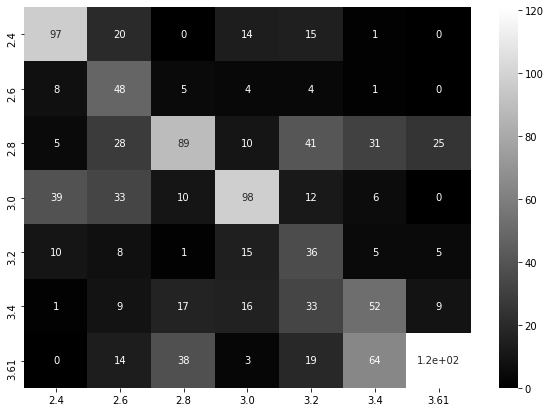

In [19]:
import seaborn as sn
import pandas as pd


cm_list = []
for one_folder in folder_list:
    splited_folder = one_folder.split("_")
    cm_list.append(splited_folder[1])
    cm_list = set(cm_list)
    cm_list = list(cm_list)
    cm_list.sort()
print(cm_list)
df_cm = pd.DataFrame(conf_mat, index = [i for i in cm_list],
                  columns = [i for i in cm_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap="gray")

<AxesSubplot:>

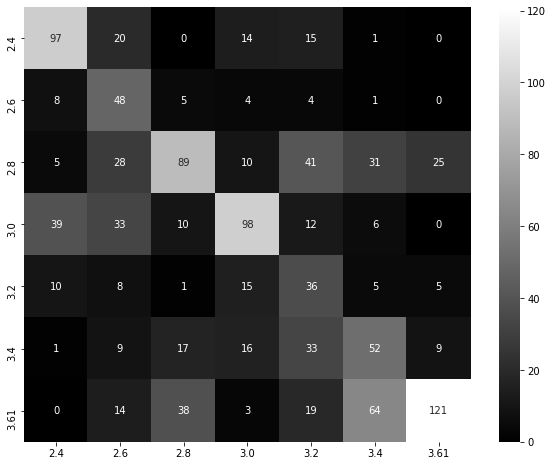

In [22]:
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True, cmap="gray", fmt="g")

In [21]:
model.save("model_2.5percent_800sample")

AttributeError: 'LeakyReLU' object has no attribute '__name__'